In [0]:
from zipfile import ZipFile
file_name="dataset.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
import numpy as np
import os
import cv2
import sys
import imageio
import glob
import matplotlib.pyplot as plt
from PIL import Image

path = "/content/dataset/"
file_list = os.listdir(path)
train_img=[]
for filename in file_list:
  fullpath = os.path.join(path,filename)
  first=Image.open(fullpath).convert('L')
  first =np.array(first)
  m,n=first.shape[0],first.shape[1]
  first=np.reshape(first,(m*n,))
  train_img.append(first)

train_img = np.asarray(train_img)
train_img = train_img.transpose()
images = [(cv2.imread(file, cv2.IMREAD_GRAYSCALE).flatten(), int(file[len(path):len(path)+3])) for file in glob.glob(path + "*.jpg")]
labels = np.array([images[i][1] for i in range(len(images))])
images = np.array([images[i][0] for i in range(len(images))])
images.shape, labels.shape

((520, 65536), (520,))

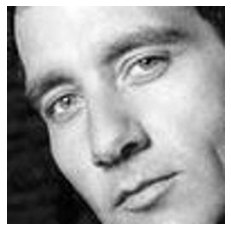

In [0]:
import matplotlib.pyplot as plt
plt.imshow(images[0, :].reshape((256, 256)), cmap="gray")
plt.axis('off')
plt.show()

# Select common feature the face 

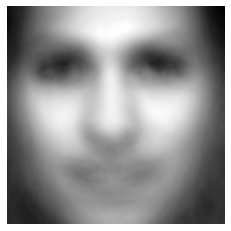

In [0]:
mean_face = images.mean(axis = 0)
plt.imshow(mean_face.reshape((256, 256)), cmap="gray")
plt.axis('off')
plt.show()

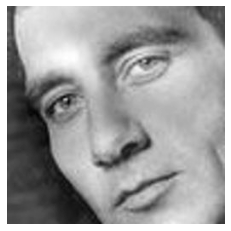

In [0]:
normalized_images = (images - mean_face.reshape(1, -1))
plt.imshow(normalized_images[0,:].reshape((256, 256)), cmap="gray")
plt.axis('off')
plt.show()

# Finding covariance of matrix

In [0]:
#to minimize the computation, covariance matrix is size of number of photos
covariance_matrix = np.matmul(normalized_images, normalized_images.T)/normalized_images.shape[0]
covariance_matrix.shape

(520, 520)

# Eigen value decomposition

In [0]:
eigen_value, eigen_vector = np.linalg.eig(covariance_matrix)
eigen_value.shape, eigen_vector.shape

((520,), (520, 520))

In [0]:
#sorting the eigen value and their corresponding eigen vectors
order = eigen_value.argsort()[::-1]
eigen_value = eigen_value[order]
avgface=np.ones((m,1))
for i in range(0,m):
    avgface[i]=np.mean(train_img[i])
eigen_vector = eigen_vector[:,order]

def calc_cov(normalized_face_vector):
  covariance_matrix = np.cov(np.transpose(normalized_face_vector))
  return covariance_matrix

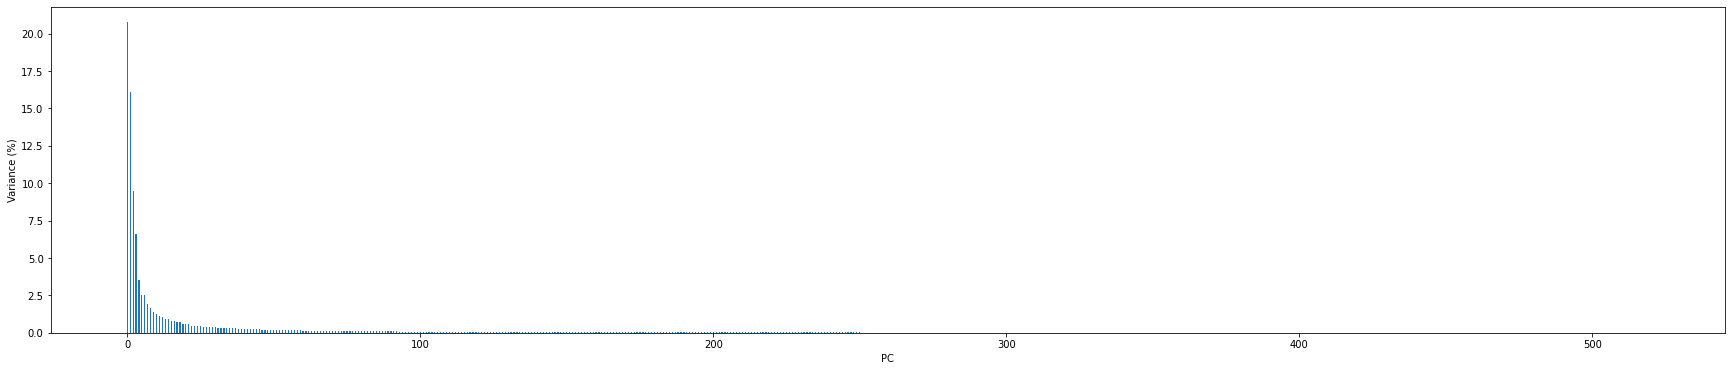

In [0]:
plt.figure(figsize=(30,6))
plt.bar(range(len(eigen_value)), (eigen_value/eigen_value.sum()*100), width=0.4)
plt.ylabel('Variance (%)')
plt.xlabel('PC')
plt.show()

# Selecting value of K for which there is 99% information is retained

In [0]:
#SELECTING GOOD VALUE OF PRINCIPLE COMPONENT
a,s,v=np.linalg.svd(covariance_matrix)
summation=np.sum(s)
for k in range(1,len(s)):
    sigma=0
    for i in range(0,k):
        sigma+=s[i]
    sigma=sigma/summation
    if(sigma>=0.98):
        print("selected value of k is",k)
        break

selected value of k is 283


In [0]:
reduced_eigen_vectors = eigen_vector[:, :k]
reduced_eigen_vectors.shape

(520, 283)

# Eigen space

In [0]:
projected_data = np.matmul(normalized_images.transpose(), reduced_eigen_vectors)
projected_data = projected_data / np.linalg.norm(projected_data, axis = 0)
projected_data.shape
eigenvectors=np.empty((k,18))
for i in range(0,k):
    temp=np.empty((1,18))
    for j in range(0,18):
        temp[0,j]=v[i,j]
    eigenvectors[i]=temp

# Finding weights of each face

In [0]:
images_weight = np.matmul(normalized_images, projected_data)
images_weight.shape

(520, 283)

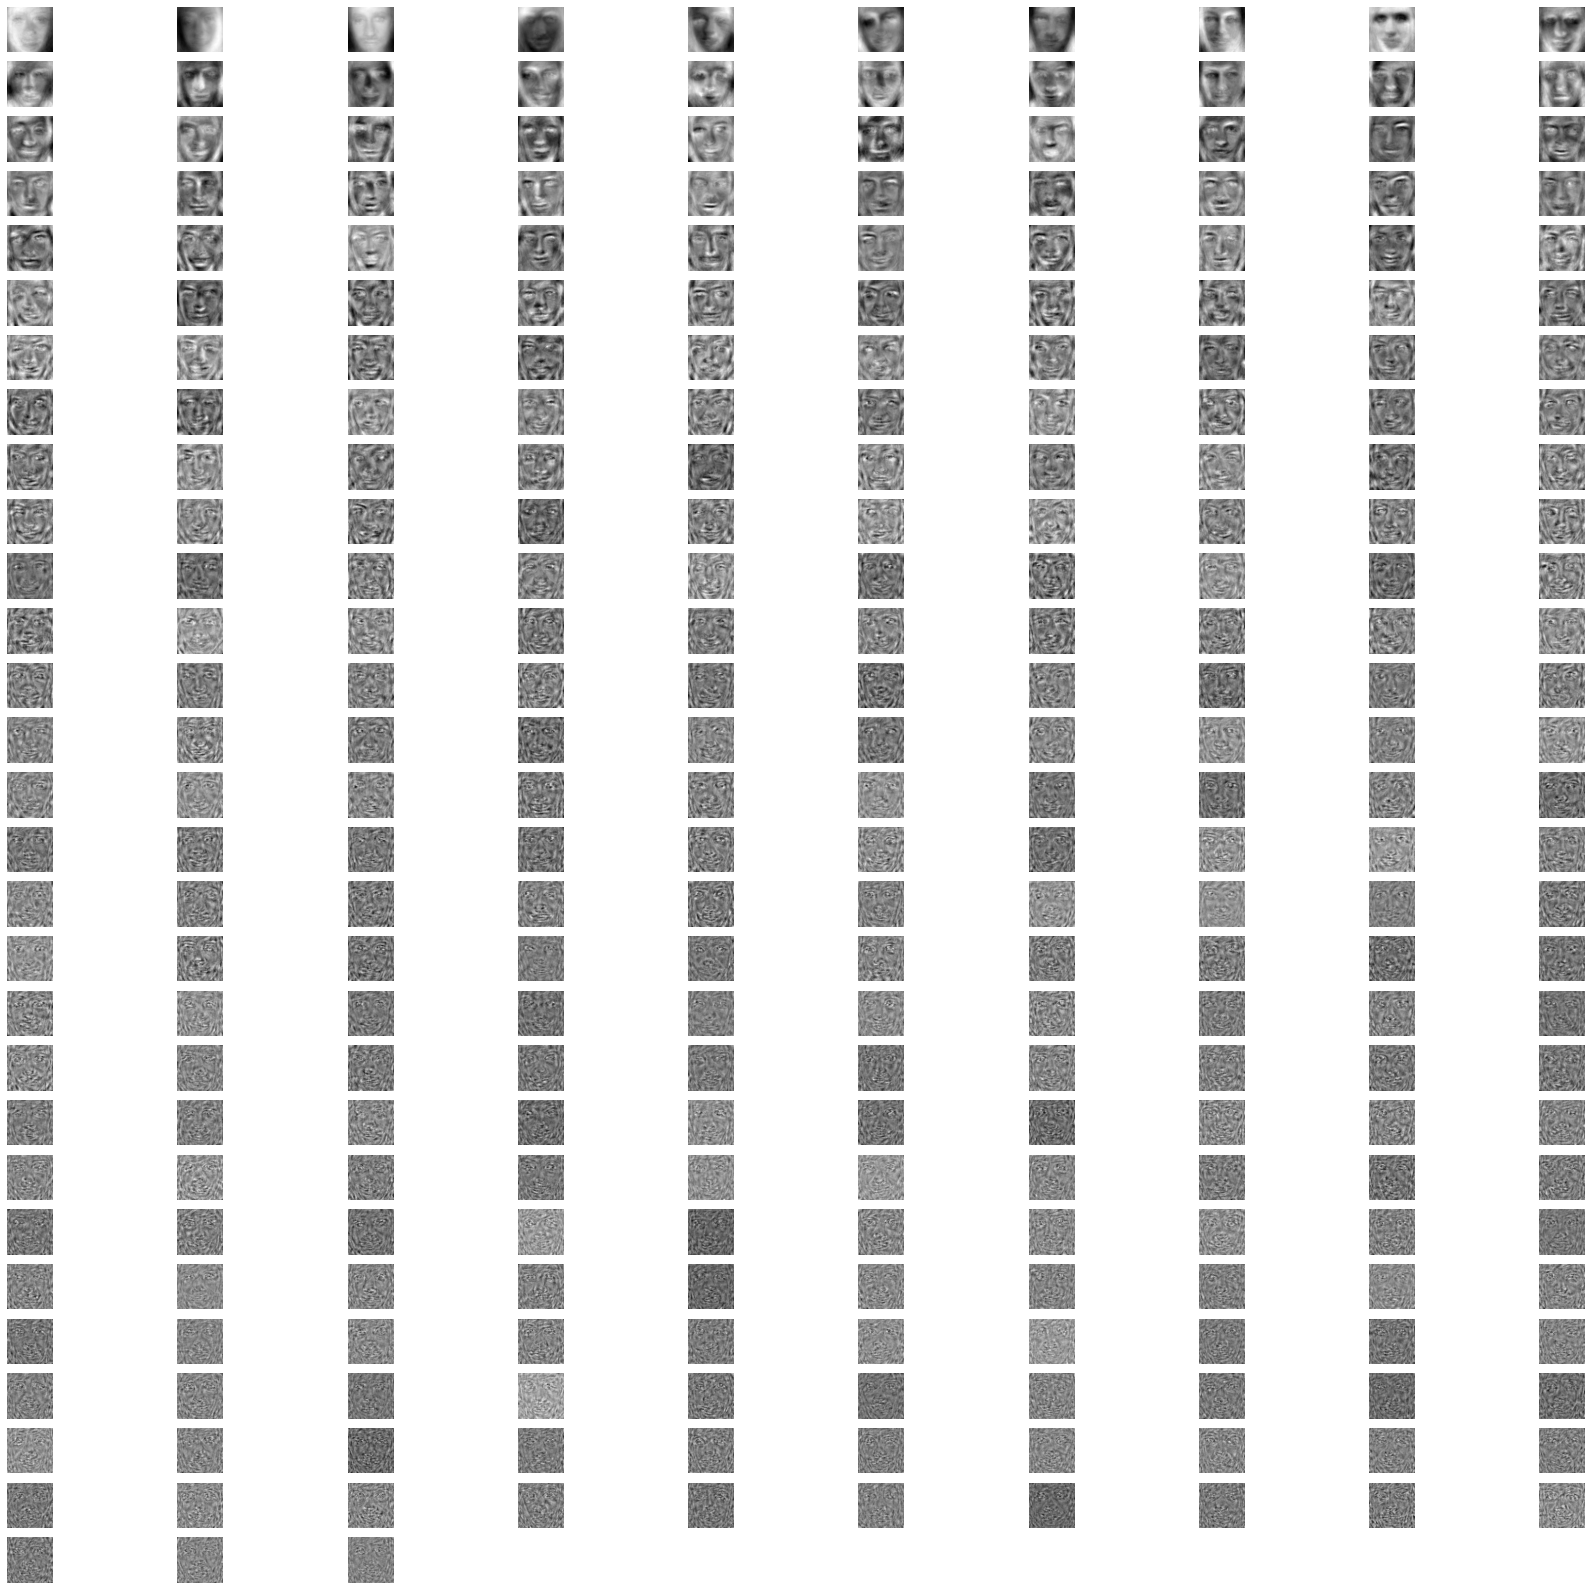

In [0]:
#ploting eigen faces
plt.figure(figsize=(30,30))
for i in range(projected_data.shape[1]):
    plt.subplot(30,10,i+1)
    plt.imshow(projected_data[:, i].reshape((256,256)), cmap='gray')
    plt.axis('off')
plt.show()

# Reconstructing image 

In [0]:
reconstructed_images = np.matmul(images_weight, projected_data.transpose()) + mean_face
reconstructed_images.shape

(520, 65536)

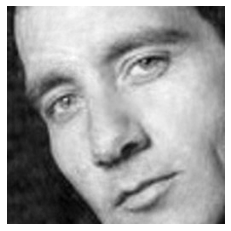

In [0]:
plt.imshow(reconstructed_images[0, :].reshape((256, 256)), cmap="gray")
plt.axis('off')
plt.show()

# MSE Graph and Scatters plots

In [0]:
mse_loss = []; no_principal_components = []
for features in range(10, 500, 10):
    reduced_eigen_vectors = eigen_vector[:, :features]
    projected_data = np.matmul(normalized_images.transpose(), reduced_eigen_vectors)
    projected_data = projected_data / np.linalg.norm(projected_data, axis = 0)
    reduced_images = np.matmul(normalized_images, projected_data)
    img_train=np.matrix(np.array(train_img))
    train_img=np.transpose(img_train)
    m,n=train_img.shape
    reconstructed_images = np.matmul(reduced_images, projected_data.transpose()) + mean_face
    mse_loss.append(((images - reconstructed_images) ** 2).sum(axis = 1).mean())
    no_principal_components.append(features)

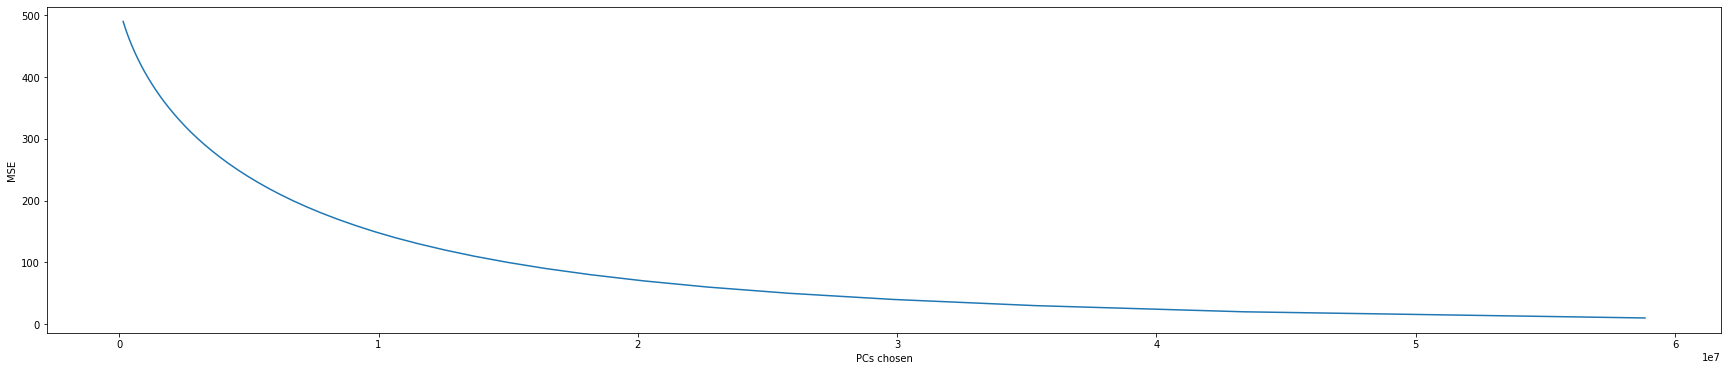

In [0]:
plt.figure(figsize = (30, 6))
plt.plot(mse_loss, no_principal_components)
plt.xlabel("PCs chosen")
plt.ylabel("MSE")
plt.show()

# scatter plots

In [0]:
# choose components
reduced_eigen_vectors = eigen_vector[:, :3]
# eigen face
projected_data = np.matmul(normalized_images.transpose(), reduced_eigen_vectors)
img_train=np.matrix(np.array(train_img))
train_img=np.transpose(img_train)
m,n=train_img.shape
projected_data = projected_data / np.linalg.norm(projected_data, axis = 0)
# reduced images
avgface=np.ones((m,1))
for i in range(0,m):
    avgface[i]=np.mean(train_img[i])
reduced_images = np.matmul(normalized_images, projected_data)
for i in range(0,n):
    img_train[i]=img_train[i]-np.transpose(avgface)


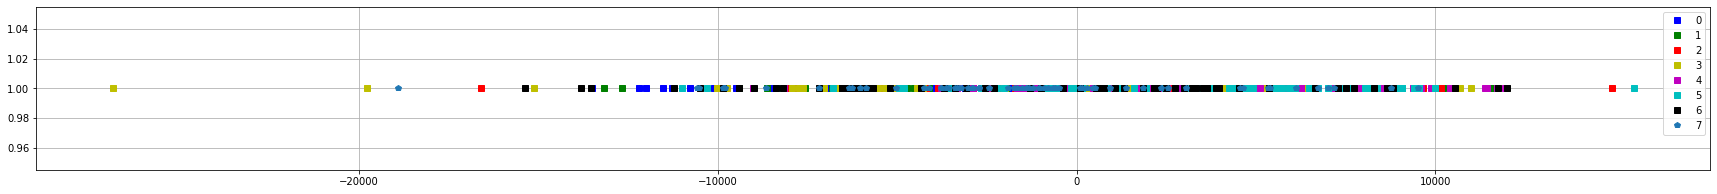

In [0]:
color_labels = ['bs', 'gs', 'rs', 'ys', 'ms', 'cs', 'ks', 'p']
plt.figure(figsize=(30, 3))
avgface=np.ones((m,1))
for i in range(0,m):
    avgface[i]=np.mean(train_img[i])
for label in np.unique(labels):
    label_images = reduced_images[labels == label, 0]
    plt.plot(label_images, np.zeros(label_images.shape) + 1, color_labels[label], label = label)
plt.legend()
plt.grid()
plt.show()

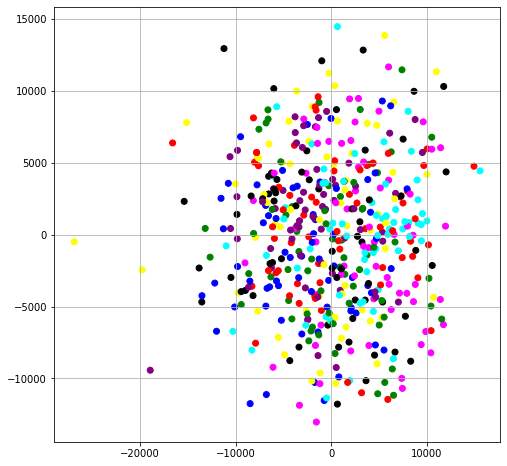

In [0]:
import matplotlib
color_labels = ['blue', 'green', 'red', 'yellow', 'magenta', 'cyan', 'black', 'purple']
plt.figure(figsize=(8, 8))
for i in range(0,n):
    img_train[i]=img_train[i]-np.transpose(avgface)
plt.scatter(reduced_images[:, 0], reduced_images[:, 1], c=labels, cmap=matplotlib.colors.ListedColormap(color_labels))
img_train=np.matrix(np.array(train_img))
train_img=np.transpose(img_train)
m,n=train_img.shape
plt.grid()
plt.show()

<Figure size 576x576 with 0 Axes>

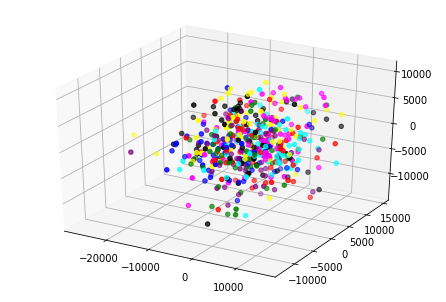

In [0]:
from mpl_toolkits.mplot3d import Axes3D
color_labels = ['blue', 'green', 'red', 'yellow', 'magenta', 'cyan', 'black', 'purple']
plt.figure(figsize=(8, 8))
fig = plt.figure()
avgface=np.ones((m,1))
for i in range(0,m):
    avgface[i]=np.mean(train_img[i])
ax = Axes3D(fig)
ax.scatter(reduced_images[:, 0], reduced_images[:, 1], reduced_images[:, 2], c=labels, cmap=matplotlib.colors.ListedColormap(color_labels))
ax.grid()
plt.show()